<a href="https://colab.research.google.com/github/troyler/photWeb/blob/main/NemoTrans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=cdb6f75d695975cf42d671944950a7d0d779889d9090815a98d8689448b5fd36
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 45 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additi

'\nRemember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!\nAlternatively, you can uncomment the exit() below to crash and restart the kernel, in the case\nthat you want to use the "Run All Cells" (or similar) option.\n'

In [23]:
import os
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

In [24]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Tarfile already exists.
Finished conversion.
******


In [28]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/FocusGroupSession5DemonstrationSample_out_2.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

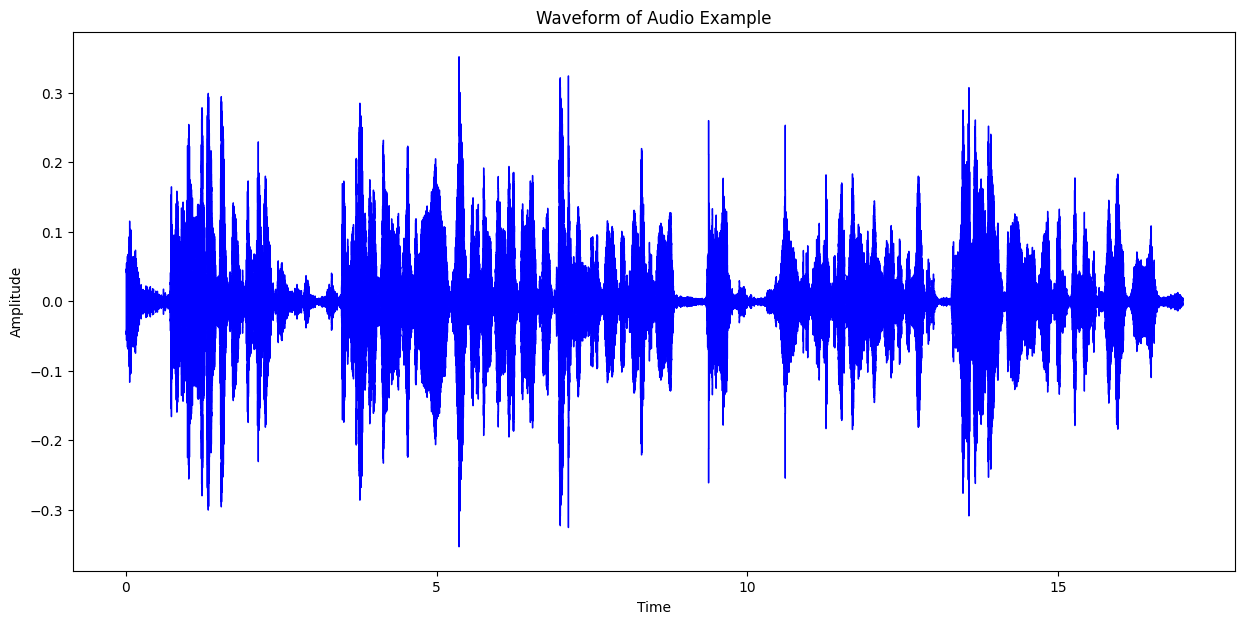

In [29]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

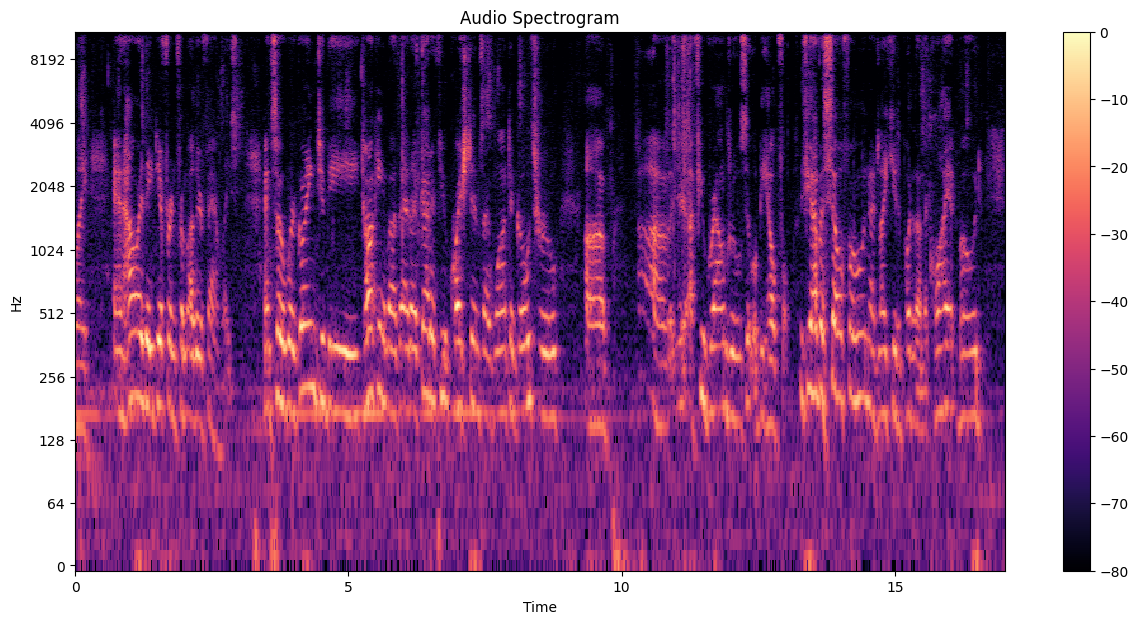

In [30]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

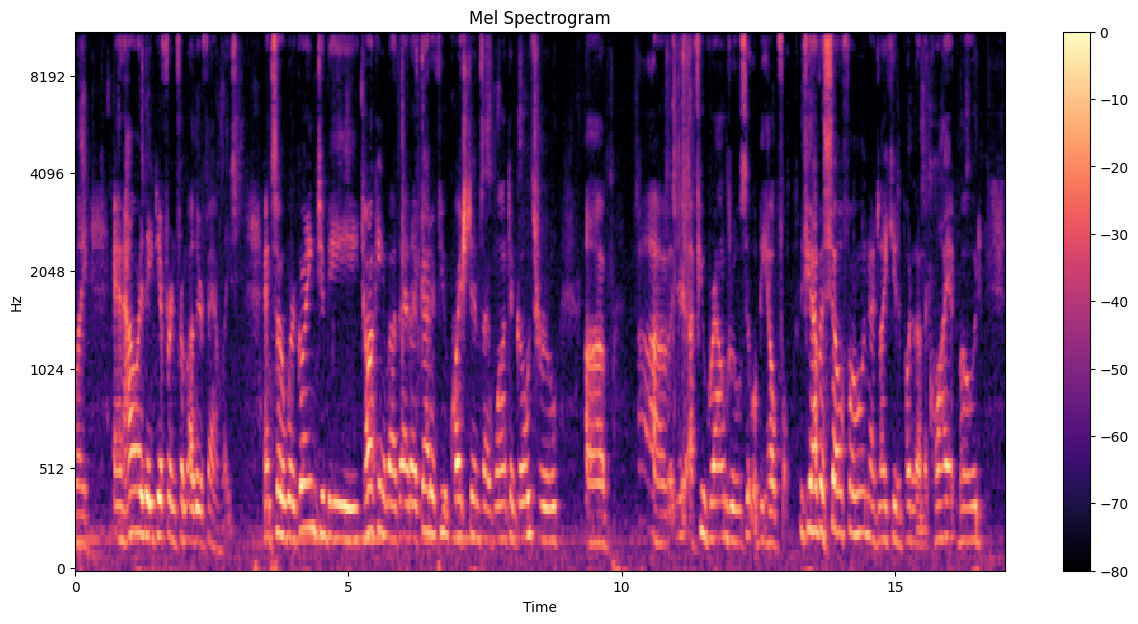

In [31]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [32]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

In [33]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-07-26 22:06:26 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_2.0.0rc2/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2024-07-26 22:06:26 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.0.0rc2/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-07-26 22:06:26 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-07-26 22:06:28 features:305] PADDING: 16
[NeMo I 2024-07-26 22:06:29 save_restore_connector:275] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0rc2/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [37]:
import librosa
import IPython.display as ipd

files = [os.path.join(data_dir, 'an4/wav/an4_clstk/FocusGroupSession5DemonstrationSample_out_2.wav')]

for fname, transcription in zip(files, quartznet.transcribe(audio=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]


TypeError: Output shape mismatch occured for audio_signal in module AudioToCharDataset : 
Output shape expected = (batch, time) | 
Output shape found : torch.Size([1, 272000, 2])

In [68]:
import librosa
import IPython.display as ipd
import numpy as np
import torch

files = [os.path.join(data_dir, 'an4/wav/an4_clstk/FocusGroupSession5DemonstrationSample_out_2.wav')]

# Set sample rate and mono for the model
quartznet.sample_rate = 16000
quartznet.cfg.preprocessor.params.mono = True  # Force mono loading

# Print the preprocessor configuration
print(quartznet.cfg.preprocessor)

# Transcribe the files directly
transcriptions = quartznet.transcribe(audio=files)

for fname, transcription in zip(files, transcriptions):
    print(f"Audio in {fname} was recognized as: {transcription}")

ConfigAttributeError: Key 'params' is not in struct
    full_key: preprocessor.params
    object_type=dict

In [69]:
import librosa
import IPython.display as ipd
import numpy as np
import torch

files = [os.path.join(data_dir, 'an4/wav/an4_clstk/FocusGroupSession5DemonstrationSample_out_2.wav')]

# Set sample rate and mono for the model
quartznet.sample_rate = 16000
quartznet.cfg.preprocessor['mono'] = True  # Force mono loading

# Print the preprocessor configuration
print(quartznet.cfg.preprocessor)

# Transcribe the files directly
transcriptions = quartznet.transcribe(audio=files)

for fname, transcription in zip(files, transcriptions):
    print(f"Audio in {fname} was recognized as: {transcription}")

ConfigKeyError: Key 'mono' is not in struct
    full_key: preprocessor.mono
    object_type=dict

In [77]:
import librosa
import IPython.display as ipd
import numpy as np
import torch
import scipy.io.wavfile as wavfile  # Import wavfile

files = [os.path.join(data_dir, 'an4/wav/an4_clstk/FocusGroupSession5DemonstrationSample_out_2.wav')]

# Set sample rate for the model
quartznet.sample_rate = 16000

# Load audio as mono using librosa
mono_audio_files = []
for fname in files:
    audio, _ = librosa.load(fname, sr=16000, mono=True)
    temp_file = 'temp_mono.wav'  # Temporary file to store mono audio
    wavfile.write(temp_file, 16000, audio)  # Use wavfile.write
    mono_audio_files.append(temp_file)

# Transcribe the mono audio files
transcriptions = quartznet.transcribe(audio=mono_audio_files)

for fname, transcription in zip(files, transcriptions):
    print(f"Audio in {fname} was recognized as: {transcription}")

# Clean up the temporary file (optional)
import os
os.remove('temp_mono.wav')

Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

Audio in ./an4/wav/an4_clstk/FocusGroupSession5DemonstrationSample_out_2.wav was recognized as: and how are they different from other families and so we're going to be talking about that i've got a few questions i want to go through of a few ground rules that would be helpful if you have a cellphone i'd like you to put it on the quiet mode
